# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "sajeevan"
ln1 = "puvikaran"
fn2 = "yanis"
ln2 = "daci"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_puvikaran_sajeevan_and_daci_yanis.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5,1,'Parameters / Coefficients')

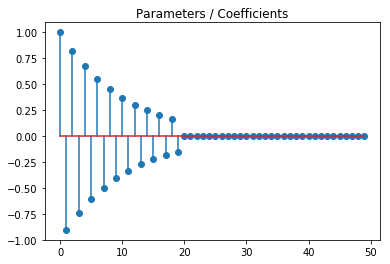

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [6]:
from numpy.linalg import norm

def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""    
    return np.sign(x) * np.maximum(np.absolute(x) - s, 0)
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * norm(x, ord=1)

def prox_ridge(x, s):
    """Proximal operator for the ridge at x"""    
    return x / (1 + s)
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return s / 2. * norm(x, ord=2) ** 2

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

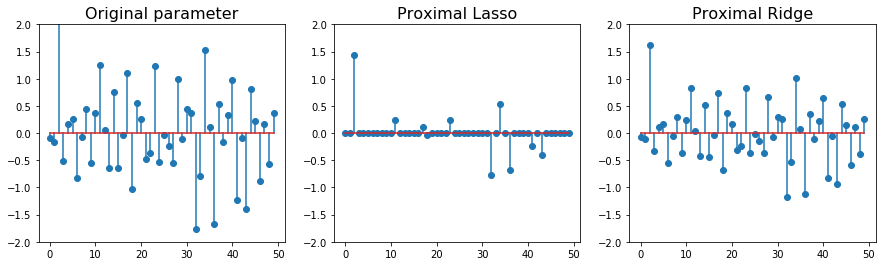

In [7]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

- For the **lasso penalization**, most of the coefficients are equals to zero because they are into the interval [-s,s] with s=1 in the visualization above. Indeed, the proximal operator can be written as prox(x, s) = sign(x)(|x| − s)+.

- For the **ridge penalization**, the coefficients are reduced but not vanished as the previous one (Coefficients divided by 1 + s). However, the bigger a coefficient is, the more the coefficient is reduced by the ridge proximal.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [8]:
from scipy.optimize import check_grad

# Linear regression
A, b = simu_linreg(x)

def loss_linreg(x):
    """Least-squares loss"""
    return norm(b - A.dot(x), ord=2) ** 2 / (2 * n_samples)

def grad_linreg(x):
    """Leas-squares gradient"""
    return - A.T.dot(b - A.dot(x)) / n_samples

print("Check gradient score for linear regression : %s\n" % 
      check_grad(loss_linreg, grad_linreg, x))

# Logistic regression
A, b = simu_logreg(x)

def loss_logreg(x):
    """Logistic loss"""
    return np.sum(np.log(1 + np.exp(-b * (A.dot(x))))) / n_samples

def grad_logreg(x):
    """Logistic gradient"""
    return np.sum(-b * A.T / (np.exp(b * A.dot(x)) + 1), axis=1) / n_samples


print("Check gradient score for logistic regression : %s\n" % 
      check_grad(loss_logreg, grad_logreg, x))

Check gradient score for linear regression : 4.368726597490479e-08

Check gradient score for logistic regression : 9.17692548608746e-09



- We can remark that the above gradients **are very closed to zero**. Therefore, we can deduce that the "grad" functions seem to be correct.

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

We know that find the Lipschitz constant is equivalent to find the smoothness constant of the function.

#### For the linear regression :

$\nabla f(x) = -\frac{A^\top}{n}(b - A x) $


By definition, $ \| \nabla f(x) - \nabla f(y)\| \leq \| \frac{A^\top A}{n}\| \| x - y\| $,  $ \forall	  x,y \in \mathbb{R^2}$

Thus, the Lipschitz constant for linear regression is * $ \| \frac{A^\top A}{n}\| $ *.
As we have seen in the practical exercises about properties and examples of convexity and smoothness :
$ L \leq \frac{\sigma_{max}{(A)}^2}{n}$ = ** $  \frac{\|A\|_2^2}{n}\ $ **.

#### For the logistic regression :

In the same way, the smoothness constant for the logistic regression is  ** $  \frac{\|A^\top A\|_2^2}{4n} \leq   \frac{\|A\|_2^2}{4n}\ $**. 

In [9]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""
    return norm(A, ord=2) ** 2 / n_samples

def lip_logreg(A):
    """Lipschitz constant for logistic loss"""
    return norm(A, ord=2) ** 2 / (4 * n_samples)

def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x_new = prox_g(x - step * grad_f(x), s * step)
        x = x_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [10]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x_new = prox_g(z - step * grad_f(z), s * step)
        t_new = (1 / 2) * (1 + np.sqrt(1 + 4 * (t ** 2)))
        z = x_new + (t - 1) * (x_new - x) / t_new
        
        x = x_new
        t = t_new

        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [11]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

## Compute a precise minimum and a precise minimizer of the linear regression with ridge penalization problem

In [12]:
A, b = simu_linreg(x)
n_iter = 1000

x_true, _, _ = fista(x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, prox_g=prox_ridge, 
                     step=1./lip_linreg(A), s=s, n_iter=n_iter, x_true=coefs, verbose=False)
x_true_fista, objectives, errors_fista = fista(x0, f=loss_linreg, grad_f=grad_linreg, 
                                               g=ridge, prox_g=prox_ridge, step=1./lip_linreg(A), s=s, n_iter=n_iter, 
                                               x_true=x_true, verbose=True)


Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.60e+00 | 8.14e-01
      10 | 6.39e-01 | 3.35e-02
      20 | 6.32e-01 | 9.12e-03
      30 | 6.31e-01 | 3.11e-03
      40 | 6.31e-01 | 1.38e-03
      50 | 6.31e-01 | 6.90e-04
      60 | 6.31e-01 | 3.58e-04
      70 | 6.31e-01 | 1.91e-04
      80 | 6.31e-01 | 1.04e-04
      90 | 6.31e-01 | 5.74e-05
     100 | 6.31e-01 | 3.19e-05
     110 | 6.31e-01 | 1.78e-05
     120 | 6.31e-01 | 9.87e-06
     130 | 6.31e-01 | 5.48e-06
     140 | 6.31e-01 | 3.04e-06
     150 | 6.31e-01 | 1.68e-06
     160 | 6.31e-01 | 9.22e-07
     170 | 6.31e-01 | 5.05e-07
     180 | 6.31e-01 | 2.75e-07
     190 | 6.31e-01 | 1.50e-07
     200 | 6.31e-01 | 8.15e-08
     210 | 6.31e-01 | 4.46e-08
     220 | 6.31e-01 | 2.47e-08
     230 | 6.31e-01 | 1.40e-08
     240 | 6.31e-01 | 8.15e-09
     250 | 6.31e-01 | 4.87e-09
     260 | 6.31e-01 | 2.99e-09
     270 | 6.31e-01 | 1.86e-09
     280 | 6.31e-01 | 1.17e-09
     290 | 6.31e-01 | 7.40e-10
     300 | 6.3

In [13]:
print("\nMinimizer : %s\n" % x_true)
print("Minimum : %s" % objectives[-1])

minimum_fista_array = objectives - objectives[-1]


Minimizer : [-0.19 -0.11  2.39 -0.42  0.11  0.27 -0.85 -0.05  0.44 -0.58  0.47  1.2
 -0.02 -0.56  0.81 -0.69 -0.04  1.13 -1.02  0.5   0.29 -0.47 -0.39  1.15
 -0.5  -0.06 -0.19 -0.59  0.95 -0.1   0.45  0.39 -1.69 -0.82  1.45  0.1
 -1.66  0.54 -0.22  0.31  0.98 -1.19 -0.17 -1.35  0.75  0.24 -0.82  0.1
 -0.51  0.39]

Minimum : 0.6311430183817026


In [14]:
# Ista for a linear regression with a ridge penalization (1000 iterations):
x_true, _, _ = ista(x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, prox_g=prox_ridge, 
                     step=1./lip_linreg(A), s=s, n_iter=n_iter, x_true=coefs, verbose=False)
x_true_ista, objectives, errors_ista = ista(x0, f=loss_linreg, grad_f=grad_linreg, 
                                               g=ridge, prox_g=prox_ridge, step=1./lip_linreg(A), s=s, n_iter=n_iter, 
                                               x_true=x_true, verbose=False)

minimum_ista_array = objectives - objectives[-1]

# Compare the convergences of ISTA and FISTA

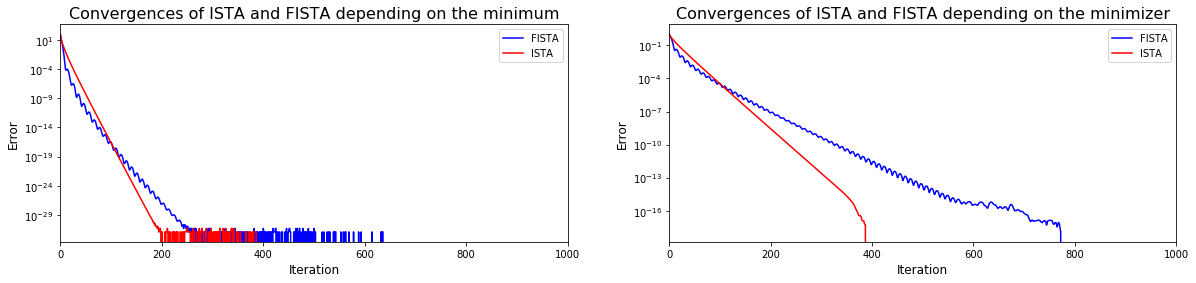

In [15]:
# Convergences of ISTA and FISTA in terms of distance to the minimum:
plt.figure(figsize=(20.0, 4.0))
plt.subplot(1, 2, 1)
plt.title("Convergences of ISTA and FISTA depending on the minimum", fontsize=16)
plt.plot(minimum_fista_array ** 2, c="blue", label="FISTA")
plt.plot(minimum_ista_array ** 2, c="red", label="ISTA")
plt.xlim(0, n_iter)
plt.yscale('log')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.legend()

# Convergences of ISTA and FISTA in terms of distance to the minimizer
plt.subplot(1, 2, 2)
plt.title("Convergences of ISTA and FISTA depending on the minimizer", fontsize=16)
plt.plot(errors_fista, c="blue", label="FISTA")
plt.plot(errors_ista, c="red", label="ISTA")
plt.xlim(0, n_iter)
plt.yscale('log')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.legend()

- We remark that FISTA converges faster than ISTA for iteration lower than 140. Then, ISTA seems to be faster than FISTA. This result is surprising as FISTA is considered as a "Fast" ISTA. In the literature, it is mentioned that ISTA is better at the final regime compared to FISTA. This might be the consequence of the complexity of FISTA algorithm. In order to perform better, ISTA and FISTA are mixed and give the hybrid F/ISTA algorithm. This method consists on using FISTA during the first regime and then passes to the ISTA algorithm when we reach the final regime. 

Furthermore, we notice that FISTA is not a descent algorithm.

We will focus on the first 100 iterations in the next graphs:

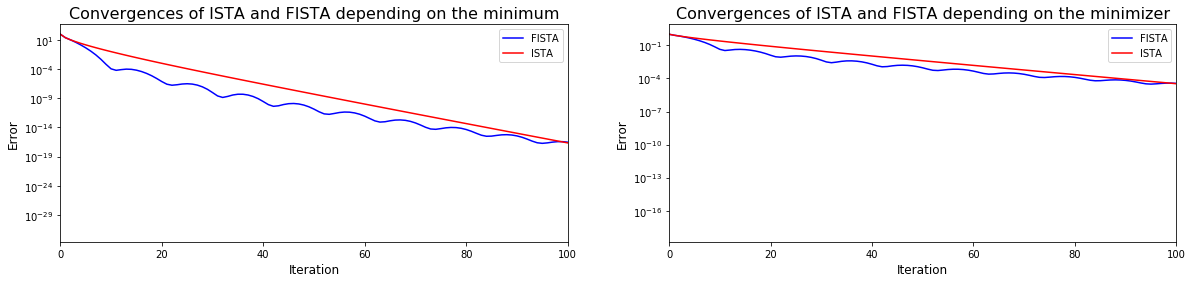

In [16]:
# Convergences of ISTA and FISTA in terms of distance to the minimum:
plt.figure(figsize=(20.0, 4.0))
plt.subplot(1, 2, 1)
plt.title("Convergences of ISTA and FISTA depending on the minimum", fontsize=16)
plt.plot(minimum_fista_array ** 2, c="blue", label="FISTA")
plt.plot(minimum_ista_array ** 2, c="red", label="ISTA")
plt.xlim(0, 100)
plt.yscale('log')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.legend()

# Convergences of ISTA and FISTA in terms of distance to the minimizer
plt.subplot(1, 2, 2)
plt.title("Convergences of ISTA and FISTA depending on the minimizer", fontsize=16)
plt.plot(errors_fista, c="blue", label="FISTA")
plt.plot(errors_ista, c="red", label="ISTA")
plt.xlim(0, 100)
plt.yscale('log')
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.legend()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

## Compare the solution you obtain with ista and fista with the true parameter coefs of the model 

<StemContainer object of 3 artists>

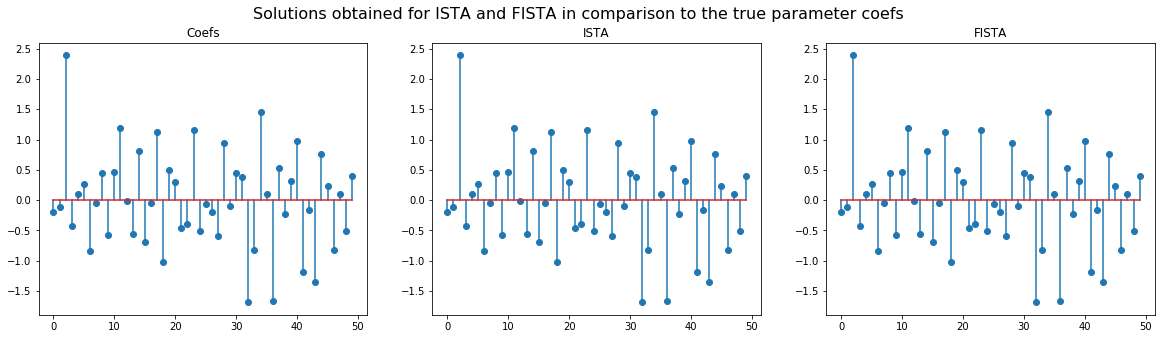

In [17]:
plt.figure(figsize=(20.0, 5.0))
plt.suptitle("Solutions obtained for ISTA and FISTA in comparison to the true parameter coefs", fontsize=16)

plt.subplot(1, 3, 1)
plt.title("Coefs")
plt.stem(x_true)

plt.subplot(1, 3, 2)
plt.title("ISTA")
plt.stem(x_true_ista)

plt.subplot(1, 3, 3)
plt.title("FISTA")
plt.stem(x_true_fista)

- The 3 graphs are identical. It proves that ISTA and FISTA are converging towards the true parameter coefs (x_true). Indeed, the errors (Third column in the previous table) for ISTA and FISTA decrease and reach the 0 value.

## Study the influence of the correlation of the features on the performance of the optimization algorithms

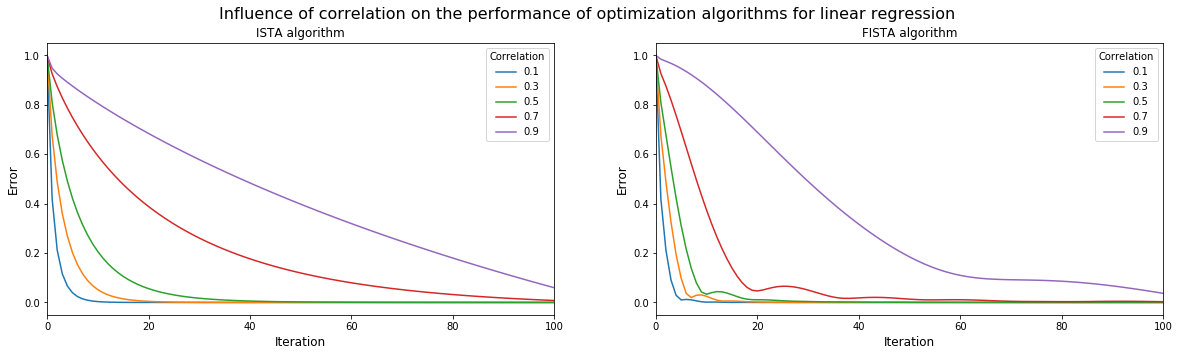

In [18]:
n_iter = 110
plt.figure(figsize=(20.0, 5.0))
plt.suptitle("Influence of correlation on the performance of optimization "
             "algorithms for linear regression", fontsize=16)
sub1 = plt.subplot(1, 2, 1)
plt.title("ISTA algorithm")
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

sub2 = plt.subplot(1, 2, 2)
plt.title("FISTA algorithm")
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

for corr in [0.1, 0.3, 0.5, 0.7, 0.9]:
    A, b = simu_linreg(x, corr=corr)    
    x_true, _, _ = ista(x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, prox_g=prox_ridge, 
                        step=1./lip_linreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_ista, objectives, errors_ista = ista(x0, f=loss_linreg, grad_f=grad_linreg, 
                                                g=ridge, prox_g=prox_ridge, step=1./lip_linreg(A), n_iter=n_iter, 
                                                x_true=x_true, verbose=False)
    
    sub1.plot(errors_ista, label=corr)
    sub1.legend(title="Correlation")

    x_true, _, _ = fista(x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, prox_g=prox_ridge, 
                         step=1./lip_linreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_fista, objectives, errors_fista = fista(x0, f=loss_linreg, grad_f=grad_linreg, 
                                                   g=ridge, prox_g=prox_ridge, step=1./lip_linreg(A), n_iter=n_iter, 
                                                   x_true=x_true, verbose=False)

    sub2.plot(errors_fista, label=corr)
    sub2.legend(title="Correlation")

Lipschitz coefficients : [0.3986212092144816, 0.530860701051446, 0.8176714375895362, 1.4855742682040802, 3.9814644857608523]


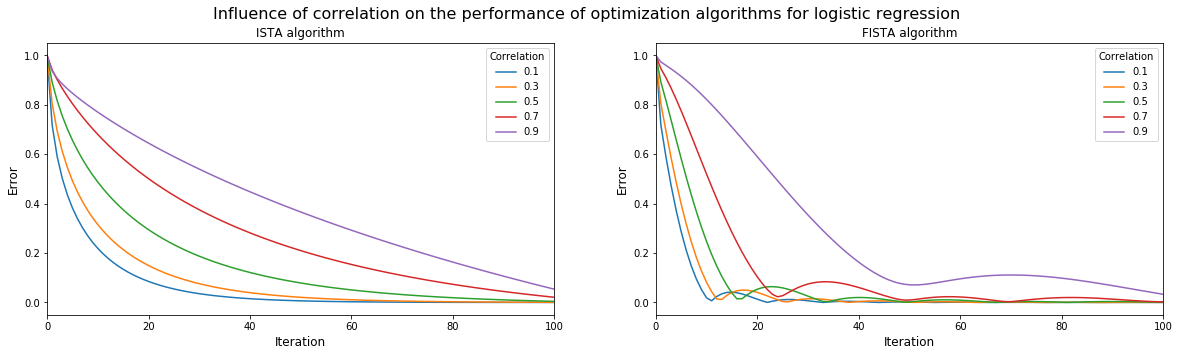

In [19]:
plt.figure(figsize=(20.0, 5.0))
plt.suptitle("Influence of correlation on the performance of optimization " 
             "algorithms for logistic regression", fontsize=16)
sub1 = plt.subplot(1, 2, 1)
plt.title("ISTA algorithm", fontsize=12)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

sub2 = plt.subplot(1, 2, 2)
plt.title("FISTA algorithm", fontsize=12)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)
lip_coeff=[]

for corr in [0.1, 0.3, 0.5, 0.7, 0.9]:
    A, b = simu_logreg(x, corr=corr)
    x_true, _, _ = ista(x0, f=loss_logreg, grad_f=grad_logreg, g=ridge, prox_g=prox_ridge, 
                        step=1./lip_logreg(A), s=s, n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_ista, objectives, errors_ista = ista(x0, f=loss_logreg, grad_f=grad_logreg, g=ridge, 
                                                prox_g=prox_ridge, step=1./lip_logreg(A), s=s, 
                                                n_iter=n_iter, x_true=x_true, verbose=False)
    
    sub1.plot(errors_ista, label=corr)
    sub1.legend(title="Correlation")

    x_true, _, _ = fista(x0, f=loss_logreg, grad_f=grad_logreg, g=ridge, prox_g=prox_ridge, 
                         step=1./lip_logreg(A), s=s, n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_fista, objectives, errors_fista = fista(x0, f=loss_logreg, grad_f=grad_logreg, g=ridge, 
                                                   prox_g=prox_ridge, step=1./lip_logreg(A), s=s, 
                                                   n_iter=n_iter, x_true=x_true, verbose=False)

    sub2.plot(errors_fista, label=corr)
    sub2.legend(title="Correlation")
    lip_coeff.append(lip_logreg(A))
    
print("Lipschitz coefficients :", lip_coeff)

- For linear or logistic regression, the smaller the correlation is, the better the convergence is. Indeed, a bigger value for correlation indicates that a feature can be found by using another one. Therefore, there are unecessary features and takes much more time to converge, whereas small correlation foster a straightforward convergence.

- We can also notice that the Lipschitz constant increases with the correlation. We know that the convergence rate of FISTA and ISTA is inversely proportional to the smoothness constant L. Therefore, convergence rate is also inversely proportional to the Lipschitz constant. Thus, if we have large correlation, the speed of convergence will be lower.

##  Study the influence of the level of ridge penalization on the performance of the optimization algorithms

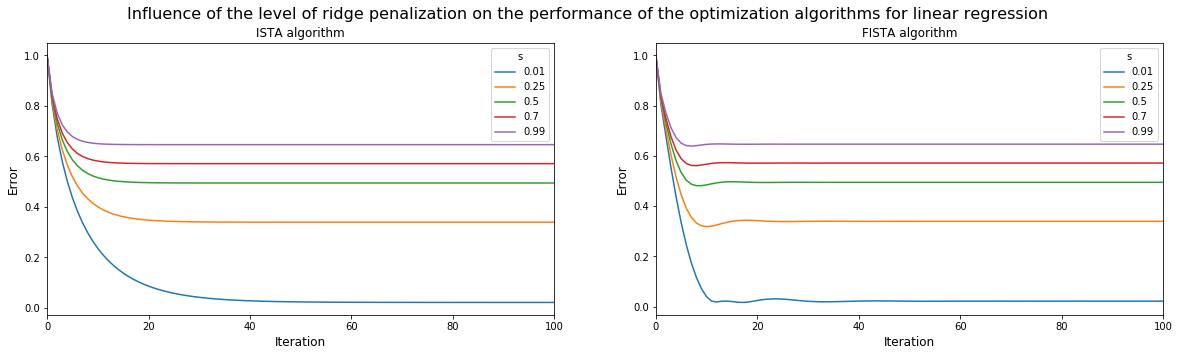

In [20]:
plt.figure(figsize=(20.0, 5.0))
plt.suptitle("Influence of the level of ridge penalization on the performance of "
             "the optimization algorithms for linear regression", 
             fontsize=16)
sub1 = plt.subplot(1, 2, 1)
plt.title("ISTA algorithm", fontsize=12)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

sub2 = plt.subplot(1, 2, 2)
plt.title("FISTA algorithm", fontsize=12)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

A, b = simu_linreg(x)

for s in [0.01, 0.25, 0.5, 0.7, 0.99]:
    x_true, _, _ = ista(x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, prox_g=prox_ridge, 
                        step=1./lip_linreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_ista, objectives, errors_ista = ista(x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, 
                                                prox_g=prox_ridge, step=1./lip_linreg(A), s=s, 
                                                n_iter=n_iter, x_true=x_true, verbose=False)
    
    sub1.plot(errors_ista, label=s)

    x_true, _, _ = fista(x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, prox_g=prox_ridge, 
                         step=1./lip_linreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_fista, objectives, errors_fista = fista(x0, f=loss_linreg, grad_f=grad_linreg, g=ridge, 
                                                   prox_g=prox_ridge, step=1./lip_linreg(A), s=s, n_iter=n_iter, 
                                                   x_true=x_true, verbose=False)

    sub2.plot(errors_fista, label=s)

sub1.legend(title="s")
sub2.legend(title="s")

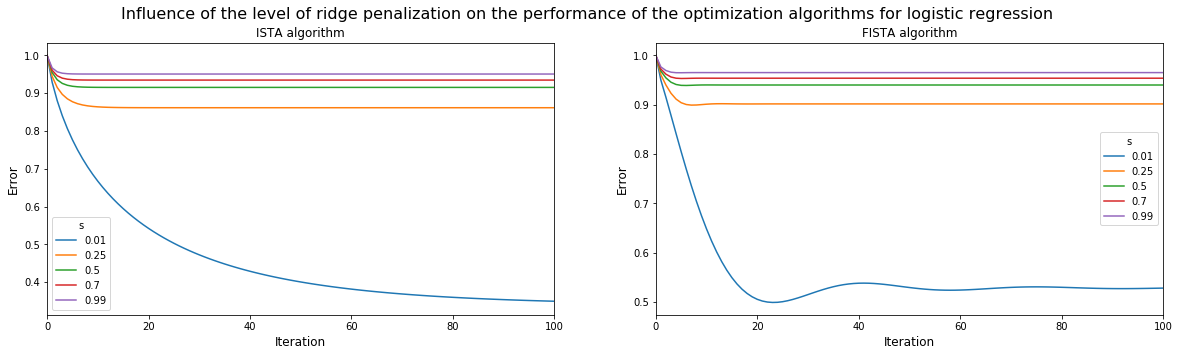

In [21]:
plt.figure(figsize=(20.0, 5.0))
plt.suptitle("Influence of the level of ridge penalization on the performance of "
             "the optimization algorithms for logistic regression", 
             fontsize=16)
sub1 = plt.subplot(1, 2, 1)
plt.title("ISTA algorithm", fontsize=12)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

sub2 = plt.subplot(1, 2, 2)
plt.title("FISTA algorithm", fontsize=12)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

A, b = simu_logreg(x)

for s in [0.01, 0.25, 0.5, 0.7, 0.99]:
    x_true, _, _ = ista(x0, f=loss_logreg, grad_f=grad_logreg, g=ridge, prox_g=prox_ridge, 
                        step=1./lip_logreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_ista, objectives, errors_ista = ista(x0, f=loss_logreg, grad_f=grad_logreg, g=ridge, 
                                                prox_g=prox_ridge, step=1./lip_logreg(A), s=s, 
                                                n_iter=n_iter, x_true=x_true, verbose=False)
    
    sub1.plot(errors_ista, label=s)

    x_true, _, _ = fista(x0, f=loss_logreg, grad_f=grad_logreg, g=ridge, prox_g=prox_ridge, 
                         step=1./lip_logreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_fista, objectives, errors_fista = fista(x0, f=loss_logreg, grad_f=grad_logreg, g=ridge, 
                                                   prox_g=prox_ridge, step=1./lip_logreg(A), s=s, n_iter=n_iter, 
                                                   x_true=x_true, verbose=False)

    sub2.plot(errors_fista, label=s)

sub1.legend(title="s")
sub2.legend(title="s")

- We can notice that a bigger penalization helps ISTA and FISTA to converge quickly in the linear or logistic case as the penalization reduces the complexity of the model. However, it concludes also with the inaccuracy of this latter. For example, an ISTA algorithm with 0.99 of regularization parameter (ridge) gives an error value of 0.96 whereas it reaches 0.35 when s = 0,01. We can conclude that there is a compromise between the rapidity of convergence and the accuracy of a model.
- More precisely, we saw in the Part 1 that the proximal of ridge is inversely proportional to s. So, the bigger s value is, the more coefficients are shrinked. Consequently, we will get a bigger error value. 

## Compare the performance of the optimization algorithms for ridge and lasso penalizations 

### Study of the performance of Ridge and Lasso depending on the regularization parameter

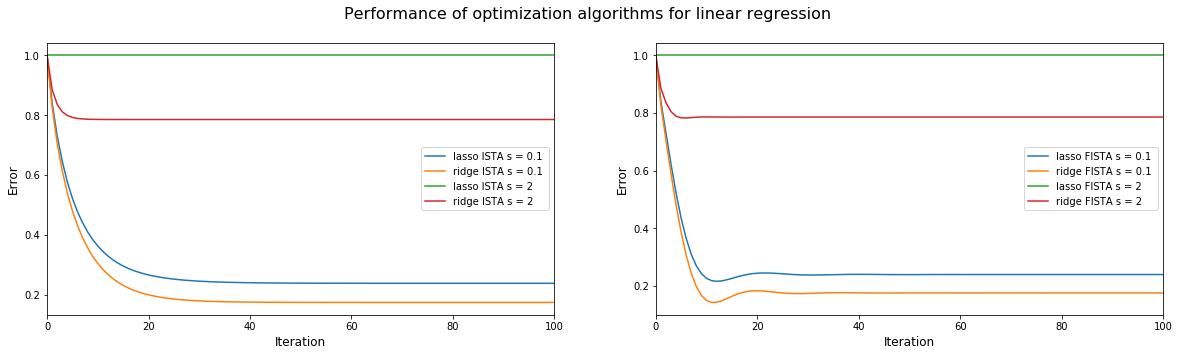

In [22]:
x0 = np.zeros(n_features)
n_iter = 110
s = 0.1

A, b = simu_linreg(x)

plt.figure(figsize=(20.0, 5.0))
plt.suptitle("Performance of optimization algorithms for linear regression", 
             fontsize=16)

sub1 = plt.subplot(1, 2, 1)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

sub2 = plt.subplot(1, 2, 2)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

for label, penalization, prox_penalization, s in [("lasso ISTA s = 0.1 ", lasso, prox_lasso, 0.1), 
                                                  ("ridge ISTA s = 0.1", ridge, prox_ridge, 0.1),
                                                  ("lasso ISTA s = 2", lasso, prox_lasso, 2),
                                                  ("ridge ISTA s = 2", ridge, prox_ridge, 2)]:
    x_true, _, _ = ista(x0, f=loss_linreg, grad_f=grad_linreg, g=penalization, prox_g=prox_penalization, 
                        step=1./lip_linreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_ista, objectives, errors_ista = ista(x0, f=loss_linreg, grad_f=grad_linreg, g=penalization, 
                                                prox_g=prox_penalization, step=1./lip_linreg(A), s=s, 
                                                n_iter=n_iter, x_true=x_true, verbose=False)
    sub1.plot(errors_ista, label=label)

for label, penalization, prox_penalization, s in [("lasso FISTA s = 0.1 ", lasso, prox_lasso, 0.1), 
                                                  ("ridge FISTA s = 0.1", ridge, prox_ridge, 0.1),
                                                  ("lasso FISTA s = 2", lasso, prox_lasso, 2),
                                                  ("ridge FISTA s = 2", ridge, prox_ridge, 2)]:
    x_true, _, _ = fista(x0, f=loss_linreg, grad_f=grad_linreg, g=penalization, prox_g=prox_penalization, 
                        step=1./lip_linreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_fista, objectives, errors_fista = fista(x0, f=loss_linreg, grad_f=grad_linreg, g=penalization, 
                                                   prox_g=prox_penalization, step=1./lip_linreg(A), s=s, 
                                                   n_iter=n_iter, x_true=x_true, verbose=False)
    sub2.plot(errors_fista, label=label)

sub1.legend()
sub2.legend()

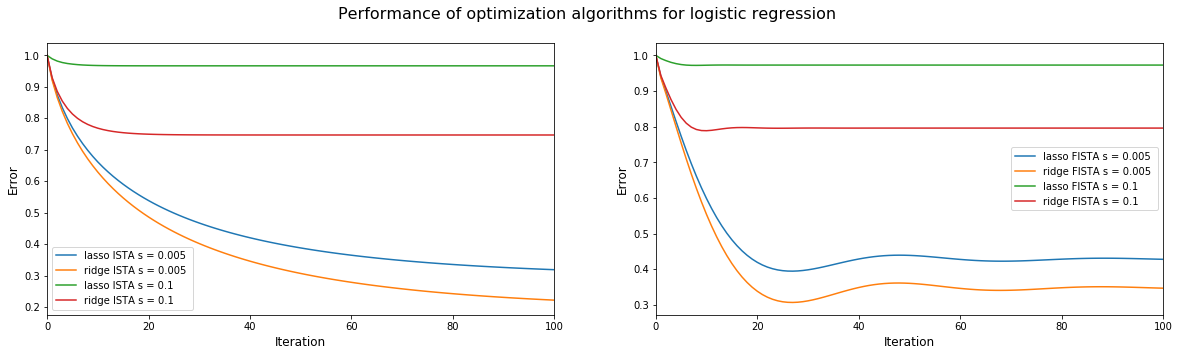

In [23]:
x0 = np.zeros(n_features)
n_iter = 110
s = 0.1

A, b = simu_logreg(x)

plt.figure(figsize=(20.0, 5.0))
plt.suptitle("Performance of optimization algorithms for logistic regression", 
             fontsize=16)

sub1 = plt.subplot(1, 2, 1)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

sub2 = plt.subplot(1, 2, 2)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

for label, penalization, prox_penalization, s in [("lasso ISTA s = 0.005 ", lasso, prox_lasso, 0.005), 
                                                  ("ridge ISTA s = 0.005", ridge, prox_ridge, 0.005),
                                                  ("lasso ISTA s = 0.1", lasso, prox_lasso, 0.1),
                                                  ("ridge ISTA s = 0.1", ridge, prox_ridge, 0.1)]:    
    x_true, _, _ = ista(x0, f=loss_logreg, grad_f=grad_logreg, g=penalization, prox_g=prox_penalization, 
                        step=1./lip_logreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_ista, objectives, errors_ista = ista(x0, f=loss_logreg, grad_f=grad_logreg, g=penalization, 
                                                prox_g=prox_penalization, step=1./lip_logreg(A), s=s, 
                                                n_iter=n_iter, x_true=x_true, verbose=False)
    sub1.plot(errors_ista, label=label)

for label, penalization, prox_penalization, s in [("lasso FISTA s = 0.005 ", lasso, prox_lasso, 0.005), 
                                                  ("ridge FISTA s = 0.005", ridge, prox_ridge, 0.005),
                                                  ("lasso FISTA s = 0.1", lasso, prox_lasso, 0.1),
                                                  ("ridge FISTA s = 0.1", ridge, prox_ridge, 0.1)]:
    x_true, _, _ = fista(x0, f=loss_logreg, grad_f=grad_logreg, g=penalization, prox_g=prox_penalization, 
                        step=1./lip_logreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_fista, objectives, errors_fista = fista(x0, f=loss_logreg, grad_f=grad_logreg, g=penalization, 
                                                   prox_g=prox_penalization, step=1./lip_logreg(A), s=s, 
                                                   n_iter=n_iter, x_true=x_true, verbose=False)
    sub2.plot(errors_fista, label=label)

sub1.legend()
sub2.legend()

- For each algorithm, when the penalization parameter is large, the penalization has a big impact on the performance. Indeed, for the Lasso penalization, the error will be very large because in this case, almost all coefficients will be equal to zero. So we will choose the Ridge penalization which has a lower error rate. When s is small, the penalization doesn't have an significantly impact on the performance. The Ridge and Lasso penalizations will be almost the same but Ridge seems to be a little more efficient.

### Study of the performance of Ridge and Lasso depending on the correlation

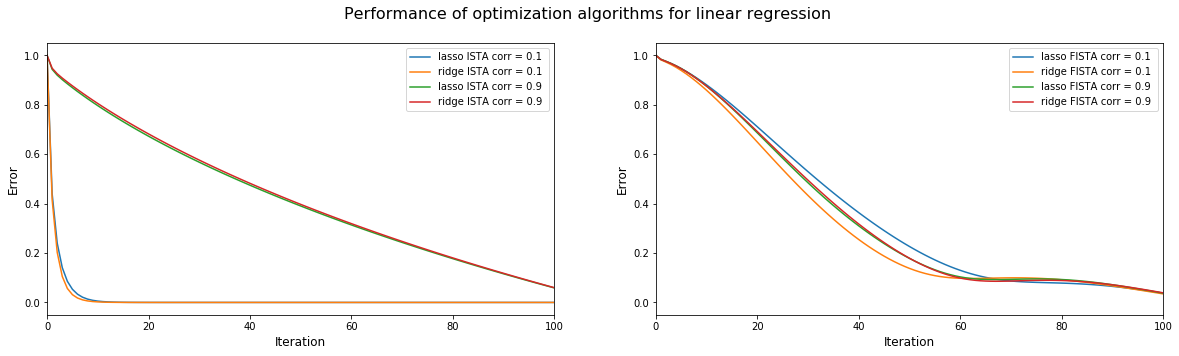

In [24]:
x0 = np.zeros(n_features)
n_iter = 110
s = 0.1

plt.figure(figsize=(20.0, 5.0))
plt.suptitle("Performance of optimization algorithms for linear regression", 
             fontsize=16)

sub1 = plt.subplot(1, 2, 1)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

sub2 = plt.subplot(1, 2, 2)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

for label, penalization, prox_penalization, corr in [("lasso ISTA corr = 0.1 ", lasso, prox_lasso, 0.1), 
                                                  ("ridge ISTA corr = 0.1", ridge, prox_ridge, 0.1),
                                                  ("lasso ISTA corr = 0.9", lasso, prox_lasso, 0.9),
                                                  ("ridge ISTA corr = 0.9", ridge, prox_ridge, 0.9)]:
    A, b = simu_linreg(x, corr=corr)
    x_true, _, _ = ista(x0, f=loss_linreg, grad_f=grad_linreg, g=penalization, prox_g=prox_penalization, 
                        step=1./lip_linreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_ista, objectives, errors_ista = ista(x0, f=loss_linreg, grad_f=grad_linreg, g=penalization, 
                                                prox_g=prox_penalization, step=1./lip_linreg(A), 
                                                n_iter=n_iter, x_true=x_true, verbose=False)
    sub1.plot(errors_ista, label=label)

for label, penalization, prox_penalization, s in [("lasso FISTA corr = 0.1 ", lasso, prox_lasso, 0.1), 
                                                  ("ridge FISTA corr = 0.1", ridge, prox_ridge, 0.1),
                                                  ("lasso FISTA corr = 0.9", lasso, prox_lasso, 0.9),
                                                  ("ridge FISTA corr = 0.9", ridge, prox_ridge, 0.9)]:
    A, b = simu_linreg(x, corr=corr)
    x_true, _, _ = fista(x0, f=loss_linreg, grad_f=grad_linreg, g=penalization, prox_g=prox_penalization, 
                        step=1./lip_linreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_fista, objectives, errors_fista = fista(x0, f=loss_linreg, grad_f=grad_linreg, g=penalization, 
                                                   prox_g=prox_penalization, step=1./lip_linreg(A), 
                                                   n_iter=n_iter, x_true=x_true, verbose=False)
    sub2.plot(errors_fista, label=label)

sub1.legend()
sub2.legend()

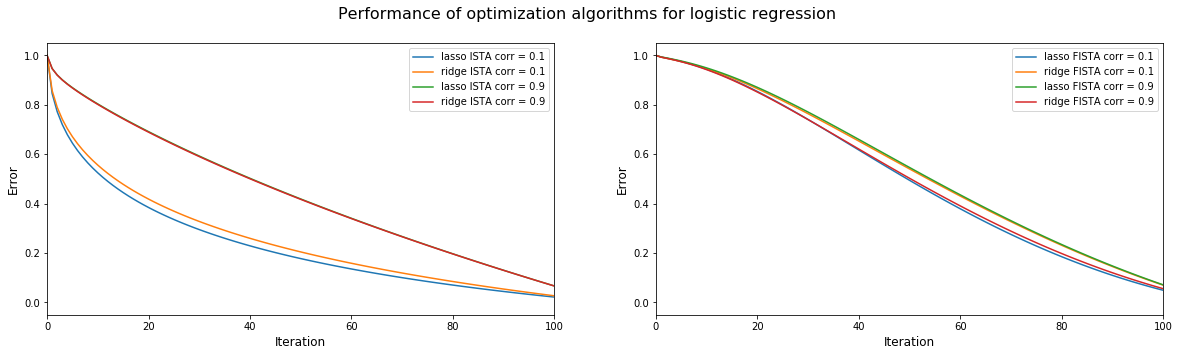

In [25]:
x0 = np.zeros(n_features)
n_iter = 110
s = 0.1

plt.figure(figsize=(20.0, 5.0))
plt.suptitle("Performance of optimization algorithms for logistic regression", 
             fontsize=16)

sub1 = plt.subplot(1, 2, 1)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

sub2 = plt.subplot(1, 2, 2)
plt.xlim(0, 100)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)

for label, penalization, prox_penalization, corr in [("lasso ISTA corr = 0.1", lasso, prox_lasso, 0.1), 
                                                  ("ridge ISTA corr = 0.1", ridge, prox_ridge, 0.1),
                                                  ("lasso ISTA corr = 0.9", lasso, prox_lasso, 0.9),
                                                  ("ridge ISTA corr = 0.9", ridge, prox_ridge, 0.9)]:
    A, b = simu_logreg(x, corr=corr)
    x_true, _, _ = ista(x0, f=loss_logreg, grad_f=grad_logreg, g=penalization, prox_g=prox_penalization, 
                        step=1./lip_logreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_ista, objectives, errors_ista = ista(x0, f=loss_logreg, grad_f=grad_logreg, g=penalization, 
                                                prox_g=prox_penalization, step=1./lip_logreg(A), 
                                                n_iter=n_iter, x_true=x_true, verbose=False)
    sub1.plot(errors_ista, label=label)

for label, penalization, prox_penalization, s in [("lasso FISTA corr = 0.1", lasso, prox_lasso, 0.1), 
                                                  ("ridge FISTA corr = 0.1", ridge, prox_ridge, 0.1),
                                                  ("lasso FISTA corr = 0.9", lasso, prox_lasso, 0.9),
                                                  ("ridge FISTA corr = 0.9", ridge, prox_ridge, 0.9)]:
    A, b = simu_logreg(x, corr=corr)
    x_true, _, _ = fista(x0, f=loss_logreg, grad_f=grad_logreg, g=penalization, prox_g=prox_penalization, 
                        step=1./lip_logreg(A), n_iter=n_iter, x_true=coefs, verbose=False)
    x_true_fista, objectives, errors_fista = fista(x0, f=loss_logreg, grad_f=grad_logreg, g=penalization, 
                                                   prox_g=prox_penalization, step=1./lip_logreg(A), 
                                                   n_iter=n_iter, x_true=x_true, verbose=False)
    sub2.plot(errors_fista, label=label)

sub1.legend()
sub2.legend()

In both cases (linear and logistic), the correlation has not a significant effect on the choice of lasso or ridge for a better performance of optimization algorithms.

- To conclude, ridge penalization is more accurate than lasso penalization for linear and logistic regression and specially for a large value of regularization parameter s.